In [89]:
!pip install netcdf4 
!pip install git+https://github.com/fujiisoup/pyspectra.git

from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyspectra
from google.colab import drive

drive.mount('/content/drive')

  Cloning https://github.com/fujiisoup/pyspectra.git to /tmp/pip-req-build-h8c839s_
  Running command git clone -q https://github.com/fujiisoup/pyspectra.git /tmp/pip-req-build-h8c839s_
  Created wheel for pyspectra: filename=pyspectra-0.0.1-cp36-none-any.whl size=18317 sha256=8c68a436cd636d4f0f0fe366d84932d1ae281141a378d7d0caaf90f358e1cc0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-22s2gao4/wheels/a7/c4/4a/152e6df7ccc3c6838abee31c086e30a3690c80966eb588e7a2
Successfully built pyspectra
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
data_dir = join('drive', 'My Drive', '研究室', 'MyLeprecon', 'SpectrometerData', '20201106')

file_names = [f'H_{430000 + 5000*i}.nc' for i in range(10)]
data = []
for file_name in file_names:
  data_array = xr.open_dataarray(join(data_dir, file_name))
  data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
  data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

plt.figure(figsize=(15, 5))
plasma_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  plasma_data.append(d.sum('y'))
plasma_data = xr.concat(plasma_data, dim='motor_coordinate')
plasma_data

<xarray.DataArray (motor_coordinate: 10, x: 2048)>
array([[1112705, 1112959, 1113278, ..., 1117614, 1117616, 1116437],
       [1119480, 1119362, 1119135, ..., 1121439, 1121714, 1122749],
       [1121754, 1120079, 1119452, ..., 1119217, 1119796, 1119437],
       ...,
       [1139127, 1132634, 1127491, ..., 1384059, 1386796, 1389542],
       [1107041, 1107395, 1107196, ..., 1103040, 1102904, 1103383],
       [1101681, 1101258, 1101259, ..., 1103001, 1104798, 1105467]],
      dtype=uint64)
Coordinates:
    image_counter     int32 0
  * x                 (x) int64 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
  * motor_coordinate  (motor_coordinate) int64 430000 435000 ... 470000 475000
    long_x            (motor_coordinate, x) int64 2047 2046 2045 ... -8999 -9000

<Figure size 1080x360 with 0 Axes>

In [91]:
file_names = [f'back_{430000 + 5000*i}.nc' for i in range(10)]
data = []
for file_name in file_names:
  data_array = xr.open_dataarray(join(data_dir, file_name))
  data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
  data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

plt.figure(figsize=(15, 5))
back_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  back_data.append(d.sum('y'))
back_data = xr.concat(back_data, dim='motor_coordinate')
back_data

<xarray.DataArray (motor_coordinate: 10, x: 2048)>
array([[1070217, 1070023, 1070392, ..., 1071270, 1071424, 1071171],
       [1070993, 1070797, 1070704, ..., 1071401, 1071897, 1071529],
       [1071235, 1070700, 1071231, ..., 1071710, 1072021, 1071801],
       ...,
       [1071492, 1071431, 1071420, ..., 1071329, 1071615, 1071947],
       [1071349, 1071631, 1071374, ..., 1071002, 1071796, 1071804],
       [1071490, 1071540, 1071493, ..., 1070927, 1071098, 1071454]],
      dtype=uint64)
Coordinates:
    image_counter     int32 0
  * x                 (x) int64 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
  * motor_coordinate  (motor_coordinate) int64 430000 435000 ... 470000 475000
    long_x            (motor_coordinate, x) int64 2047 2046 2045 ... -8999 -9000

<Figure size 1080x360 with 0 Axes>

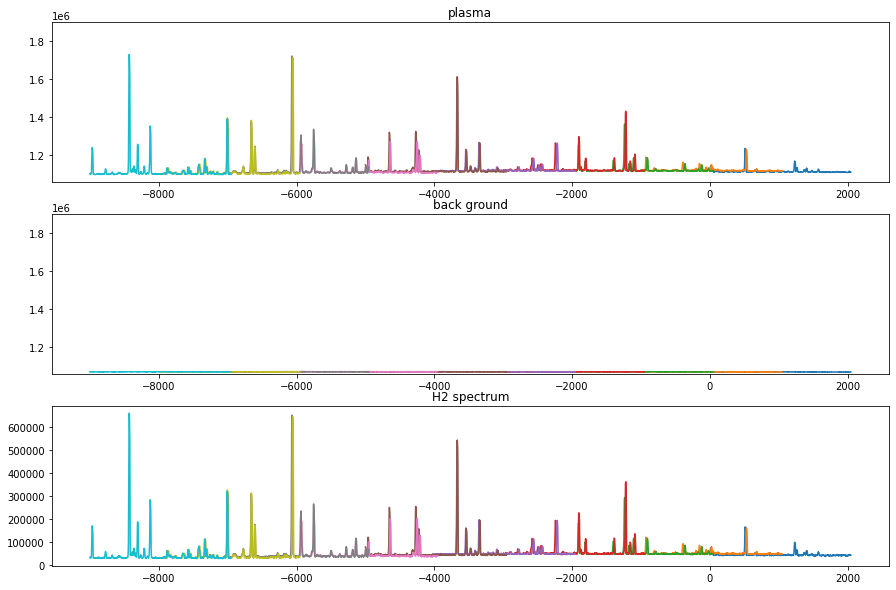

In [94]:
spectrum_data = plasma_data - back_data * 1.0

plt.figure(figsize=[15, 10])
plt.subplot(3, 1, 1)
plt.ylim(1.06*1e6, 1.9*1e6)
plt.title('plasma')
for f in plasma_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 2)
plt.title('back ground')
plt.ylim(1.06*1e6, 1.9*1e6)
for f in back_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 3)
plt.title('H2 spectrum')
for f in spectrum_data:
  plt.plot(f['long_x'], f)

##Q1

In [95]:
def fit(da):
  popt, perr = pyspectra.fit.singlepeak_fit(da['x'].values, da.values)
  return xr.Dataset({
      'A': popt[0], 'x0': popt[1], 'w': popt[2], 'y0': popt[3],
      'data': da,
      'fit': ('x', pyspectra.profiles.Gauss(da['x'].values, *popt))},
      coords={'x': da['x']})

Text(-7230, 100000, 'N=6')

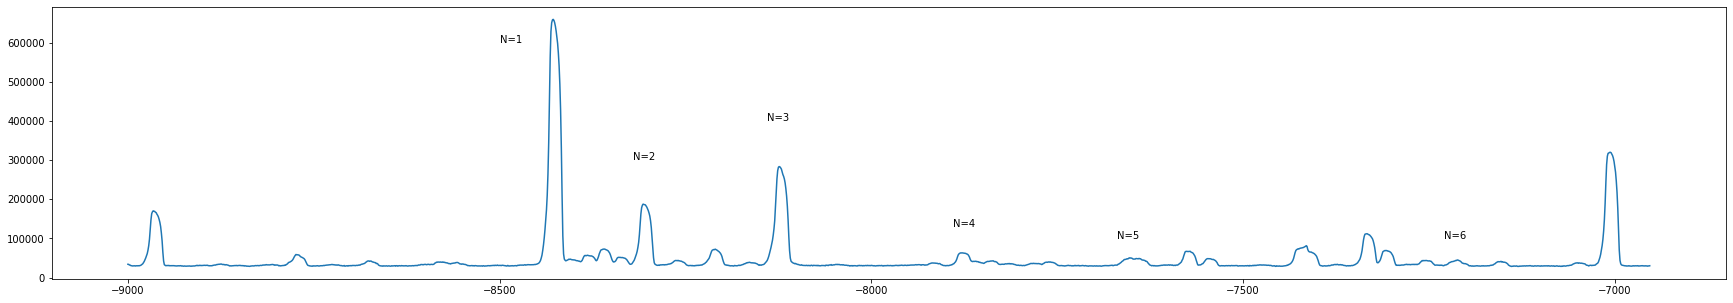

In [120]:
plt.figure(figsize=(30, 5))
plt.plot(spectrum_data[9]['long_x'], spectrum_data[9])
plt.text(-8500, 600000, 'N=1')
plt.text(-8320, 300000, 'N=2')
plt.text(-8140, 400000, 'N=3')
plt.text(-7890, 130000, 'N=4')
plt.text(-7670, 100000, 'N=5')
plt.text(-7230, 100000, 'N=6')
#plt.plot(spectrum_data[9]['x'], spectrum_data[9])
#plt.xlim(200, 600)
#plt.ylim(-5000, 200000)

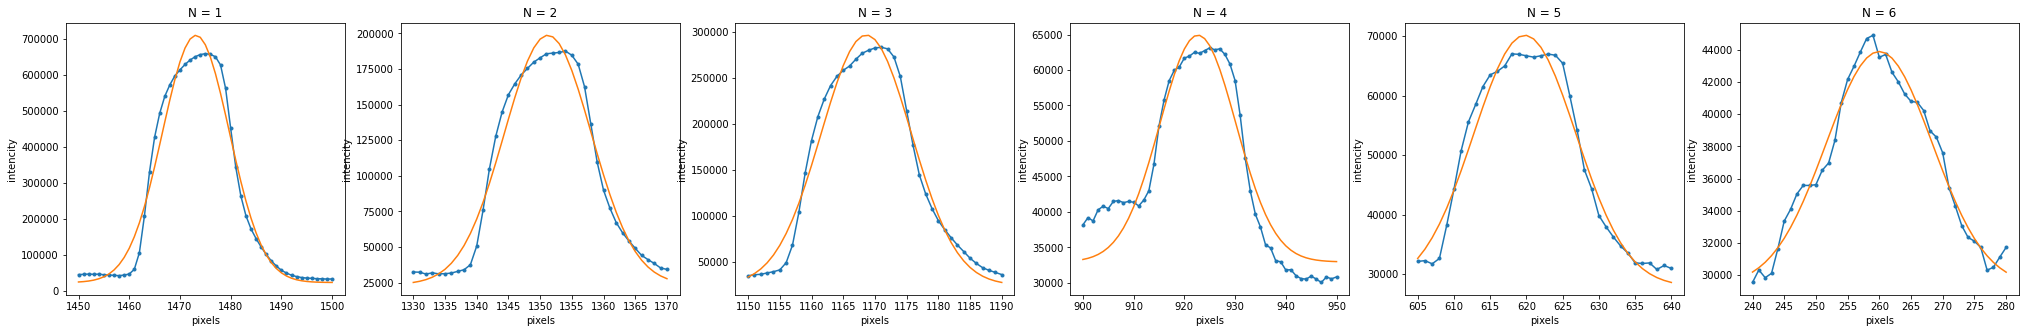

In [121]:
spectrum_lims = [
  [1450, 1500],
  [1330, 1370],
  [1150, 1190],
  [900, 950],
  [605, 640],
  [240, 280]
]
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
  610.9030
]
plt.figure(figsize=(35, 5))
Q1_result = []

for i, lims in enumerate(spectrum_lims):
  result = fit(spectrum_data.sel(motor_coordinate=475000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
  result['v'] = 0
  result['N'] = i+1
  result['wave_length'] = wave_lengths[i]
  plt.subplot(1, len(spectrum_lims), i+1)
  result['data'].plot(marker='.')
  result['fit'].plot()
  plt.title('N = {}'.format(i+1))
  plt.xlabel('pixels')
  plt.ylabel('intencity')
  Q1_result.append(result)
Q1_result = xr.concat(Q1_result, dim='N')

<xarray.DataArray 'x0' (N: 6)>
array([1473.15386295, 1351.21235059, 1168.6366258 ,  922.67407858,
        619.78637382,  259.98825571])
Coordinates:
    motor_coordinate  int64 475000
    image_counter     int32 0
  * N                 (N) int64 1 2 3 4 5 6


Text(0, 0.5, 'area')

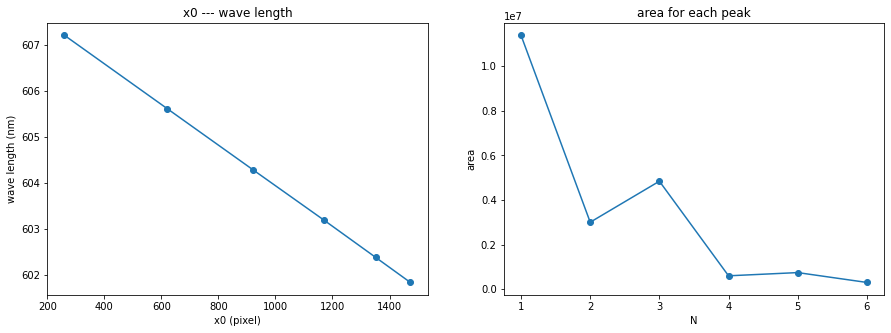

In [161]:
for i, re in enumerate(Q1_result['x0']):
#  print(spectrum_data.sel(motor_coordinate=475000).isel(x=int(re[i]))['long_x'])
#print(spectrum_data.sel(motor_coordinate=475000).isel(x=int(Q1_result['x0'][0]))['long_x'])

plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(Q1_result['x0'], Q1_result['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')
plt.subplot(1, 2, 2)
plt.plot(Q1_result['N'], Q1_result['A'], marker='o')
plt.title('area for each peak')
plt.xlabel('N')
plt.ylabel('area')

In [122]:
# d状態の回転エネルギー
def e_rot(v, N):
  return (30.364-1.545*(v+1/2))*N*(N+1)-0.0191*N*(N+1)*N*(N+1)

# 核スピンの縮退度(核スピンの統計重率)
def g_as(N):
  return (N % 2) * 2 + 1

# 回転の統計重率(もしかしたら二乗じゃ無いかも)
def g_N(N):
  return (2*N+1)*(2*N+1)

Text(0.5, 1.0, 'upper enegy -- population')

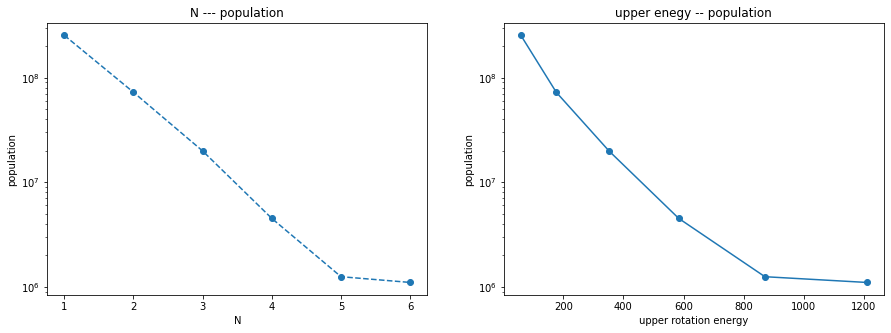

In [123]:
plt.figure(figsize=[15, 5])

Q1_population = Q1_result['A'] * Q1_result['wave_length'] / g_N(Q1_result['N']) / g_as(Q1_result['N'])
#Q2_population = Q2_result['A'] * Q2_result['wave_length'] / g_N(Q2_result['N']) / g_as(Q2_result['N'])
#Q3_population = Q3_result['A'] * Q3_result['wave_length'] / g_N(Q3_result['N']) / g_as(Q3_result['N'])

plt.subplot(1, 2, 1)
Q1_population.plot(marker='o', ls='--')
#Q2_population.plot(marker='o', ls='--')
#Q3_population.plot(marker='o', ls='--')
plt.yscale('log')
plt.title('N --- population')
plt.xlabel('N')
plt.ylabel('population')

plt.subplot(1, 2, 2)
plt.semilogy(e_rot(Q1_result['v'], Q1_result['N']), Q1_population, '-o')
#plt.semilogy(e_rot(Q2_result['v'], Q2_result['N']), Q2_population, '-o')
#plt.semilogy(e_rot(Q3_result['v'], Q3_result['N']), Q3_population, '-o')
plt.xlabel('upper rotation energy')
plt.ylabel('population')
plt.title('upper enegy -- population')